<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/07-question-answering/question_answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Question Answering

##Setup

In [ ]:
!pip -q install transformers[sentencepiece]
!pip -q install datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering
from datasets import get_dataset_config_names
from datasets import load_dataset


In [3]:
import os
import logging
from subprocess import Popen, PIPE, STDOUT

for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
              "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base", 
              "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

##The Dataset

In [6]:
# use the get_dataset_config_names() function to find out which subsets are available
domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [ ]:
# let's download the electronics subset
subjqa = load_dataset("subjqa", "electronics")

In [ ]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [7]:
# convert each split to a Pandas DataFrame
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [8]:
# Let’s focus on these columns and take a look at a few of the training examples
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]

sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [9]:
# use the start index and length of the answer span to slice out the span of text in the review that corresponds to the answer
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx: end_idx]

'this keyboard is compact'

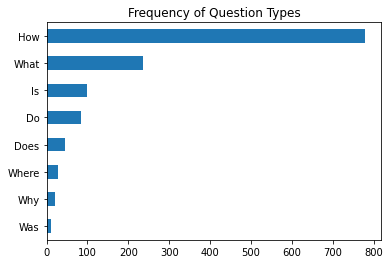

In [10]:
# let’s get a feel for what types of questions are in the training set by counting the questions that begin with a few common starting words
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [11]:
# let’s have a look at some examples
for question_type in ["How", "What", "Is"]:
  for question in (dfs["train"][dfs["train"].question.str.startswith(question_type)].sample(n=3, random_state=42)["question"]):
    print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


##Extracting Answers from Text

In [ ]:
# let's load the MiniLM model checkpoint
model_ckpt = "deepset/minilm-uncased-squad2"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

To see the model in action, let’s first try to extract an answer from a short passage of text. 

In extractive QA tasks, the inputs are provided as (question, context) pairs.

In [13]:
question = "How much music can this hold?"
context = """ An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [14]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
# let’s decode the input_ids tensor
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


Now, we just need to instantiate the model with a QA head
and run the inputs through the forward pass.

In [15]:
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

In [16]:
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [17]:
# get the logits for the start and end tokens
start_logits = outputs.start_logits
end_logits = outputs.end_logits

print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


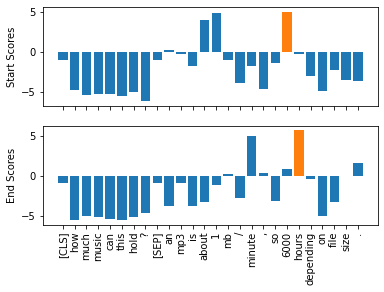

In [18]:
s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

To get the final answer, we can compute the argmax over the start and end token logits
and then slice the span from the inputs.

In [19]:
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1

answer_span = inputs["input_ids"][0][start_idx : end_idx]
answer = tokenizer.decode(answer_span)

print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In Transformers, all of these preprocessing and postprocessing
steps are conveniently wrapped in a dedicated pipeline.

In [22]:
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, top_k=3)

[{'answer': '6000 hours', 'end': 49, 'score': 0.2651623487472534, 'start': 39},
 {'answer': '1 MB/minute, so about 6000 hours',
  'end': 49,
  'score': 0.22082945704460144,
  'start': 17},
 {'answer': '1 MB/minute',
  'end': 28,
  'score': 0.10253474861383438,
  'start': 17}]

In [23]:
# it is possible to have questions for which no answer is possible
pipe(question="Why is there no data?", context=context, handle_impossible_answer=True)

{'answer': '', 'end': 0, 'score': 0.9068416357040405, 'start': 0}

##Dealing with long passages

For other tasks, like text classification, we simply truncated long texts under the
assumption that enough information was contained in the embedding of the `[CLS]`
token to generate accurate predictions. 

For QA, however, this strategy is problematic
because the answer to a question could lie near the end of the context and thus would
be removed by truncation.

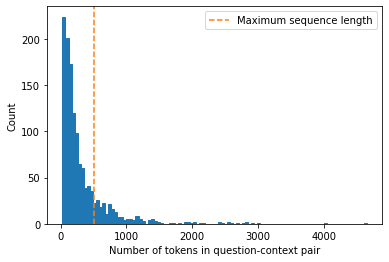

In [24]:
#caption Distribution of tokens for each question-context pair in the SubjQA training set
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1", label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

The standard way to deal with this is to apply a sliding window across the inputs, where each window contains a passage of tokens that fit in the model’s context.

In [ ]:
# Let’s grab the first example from our training set and define a small window
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True,
                              max_length=100,
                              stride=25)

In [27]:
# Let’s check the number of tokens we have in each window
for idx, window in enumerate(tokenized_example["input_ids"]):
  print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [28]:
# Finally, we can see where two windows overlap by decoding the inputs
for window in tokenized_example["input_ids"]:
  print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



##Using Haystack to Build a QA Pipeline